In [7]:
import commpy as cp
import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import math
from multiprocessing import Pool
import traceback
import warnings
import sys
from sklearn.metrics import mean_squared_error

In [8]:
def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/20.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    
    return y.flatten()

def calc_accuracy(original, predictions):
    return np.sum(original == predictions) / (original.shape[0] * original.shape[1])

In [9]:
def generate_combined_dataset_qam_4_edited(dataset_size,  preamble_length, data_length, channel_length, SNR, constellations):
    QAMModem = cp.modulation.QAMModem(constellations)
    
    # use the constellation object to modulate the data bits into complex numbers
    
    
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    
    for i in range(dataset_size):
        input_data_bits = np.random.randint(0, 2, data_length)
        preambles = np.random.randint(0, 2, preamble_length)
        
        input_data_constellation = QAMModem.modulate(input_data_bits)
        real_input = np.real(input_data_constellation)
        im_input = np.imag(input_data_constellation)
        real_im_input = np.vstack((real_input,im_input)).T
        input_data_constellations.append(real_im_input)
        
        preambles_constellation =  QAMModem.modulate(preambles)
        real_preambles = np.real(preambles_constellation)
        im_preambles = np.imag(preambles_constellation)
        real_im_preambles = np.vstack((real_preambles,im_preambles)).reshape((-1,),order='F')
        preambles_constellations.append(real_im_preambles)
        
        channel_taps = np.random.uniform(-1, 1, channel_length)
        channel_taps = channel_taps / np.linalg.norm(channel_taps)
        channels.append(channel_taps)
       
        preamble_conv = sig.convolve(preambles_constellation, channel_taps, mode='same')
        real_preambles_conv = np.real(preamble_conv)
        im_preambles_conv = np.imag(preamble_conv)
        real_im_preambles_conv = np.vstack((real_preambles_conv,im_preambles_conv)).reshape((-1,),order='F')
        convolved_preambles.append(real_im_preambles_conv)
        
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellation, channel_taps, mode='same'), SNR)
        real_constellation_conv = np.real(constellation_convolved)
        im_constellation_conv = np.imag(constellation_convolved)
        real_im_constellation_conv = np.vstack((real_constellation_conv,im_constellation_conv)).T
        convolved_data_constellations.append(real_im_constellation_conv)
        
    X1 = np.hstack([preambles_constellations, np.array(convolved_preambles)])
    X2 = np.array(convolved_data_constellations)
    Y = np.array(input_data_constellations)
    channels = np.array(channels)
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X1, X2, Y, channels

In [10]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
def build_end_to_end_model_regression_larger_bidir_real_im_features(preamble_length,
                                                                    data_length,
                                                                    channel_length,
                                                                    output_length):
    preamble = Input(shape=(preamble_length,))
    data = Input(shape=(data_length, 2))
    
    
    preamble_layer_1 = Dense(300, activation='relu')(preamble)
    preamble_layer_2 = Dense(300, activation='relu')(preamble_layer_1)
    
    channel = Dense(channel_length, activation='sigmoid')(preamble_layer_2)
    
    channel_repeated = RepeatVector(data_length)(channel)
    
    output = concatenate([data, channel_repeated])
    data_layers = Bidirectional(LSTM(45, return_sequences=True))(output)
    data_layers_2 = Bidirectional(LSTM(45, return_sequences=True))(data_layers)
    
    output_1 = TimeDistributed(Dense(output_length, activation='relu'))(data_layers_2)
    output = TimeDistributed(Dense(2, activation='linear'))(output_1)
    model = Model(inputs=[preamble, data], outputs=[output])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [11]:
preamble_length = 80
data_length = 400
dataset_size = 100000
channel_length = 2
SNR = 10
QAM_scheme = 4
preamble_data, convolved_data, input_data_symbols, channels = generate_combined_dataset_qam_4_edited(dataset_size, preamble_length, data_length, channel_length, SNR, QAM_scheme)
train_size = int(input_data_symbols.shape[0] * 0.8)
preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
channel_train, channel_test = channels[:train_size], channels[train_size:]
print(preamble_train.shape, preamble_test.shape)
print(convolved_train.shape, convolved_test.shape)
print(input_data_symbols_train.shape, input_data_symbols_test.shape)
print(channel_train.shape, channel_test.shape)
print(channels)

((80000, 160), (20000, 160))
((80000, 200, 2), (20000, 200, 2))
((80000, 200, 2), (20000, 200, 2))
((80000, 2), (20000, 2))
[[ 0.83967929  0.54308259]
 [ 0.42584251  0.9047973 ]
 [-0.48582933 -0.8740537 ]
 ...
 [-0.68199588 -0.73135601]
 [-0.22441639  0.97449335]
 [ 0.42126576 -0.90693724]]


In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


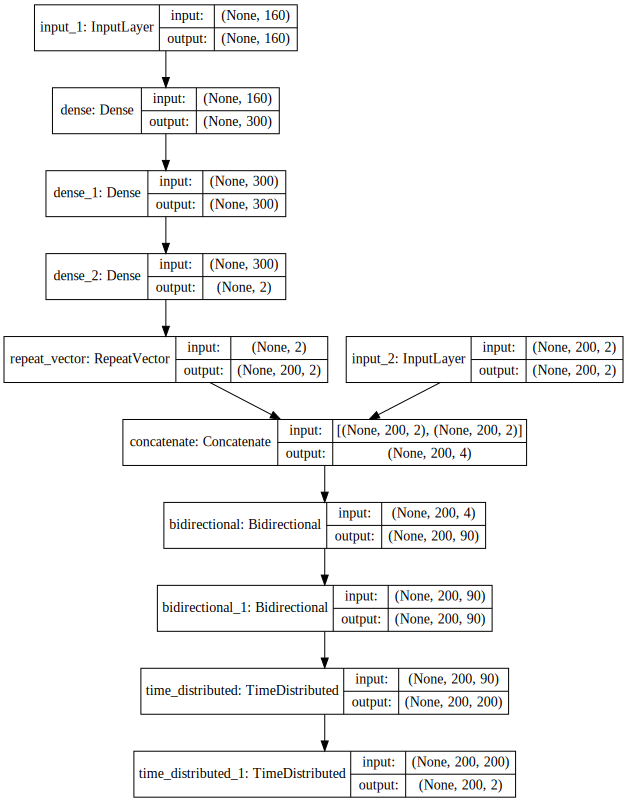

In [13]:
model = build_end_to_end_model_regression_larger_bidir_real_im_features(preamble_train.shape[1],
                                                                        convolved_train.shape[1],
                                                                        channel_length,
                                                                        input_data_symbols_train.shape[1])
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
model.fit([preamble_train, convolved_train], [input_data_symbols_train], validation_data=([preamble_test, convolved_test], [input_data_symbols_test]), epochs=30, batch_size=64)

Train on 80000 samples, validate on 20000 samples
Epoch 1/30
80000/80000 [==============================] - 2521s 32ms/step - loss: 0.4413 - mean_squared_error: 0.4413 - val_loss: 0.2248 - val_mean_squared_error: 0.2248
Epoch 2/30
17472/80000 [=====>........................] - ETA: 30:19 - loss: 0.2196 - mean_squared_error: 0.2196

In [ ]:
predictions = model.predict([preamble_test, convolved_test])
rounded_predictions = np.where(predictions > 0, 1, -1)
print(rounded_predictions.shape, input_data_symbols_test.shape)

In [ ]:
rounded_predictions_reshaped = rounded_predictions.reshape((4000000, 2))
test_data_reshaped = input_data_symbols_test.reshape((4000000, 2))
calc_accuracy(rounded_predictions_reshaped, test_data_reshaped)

In [ ]:
correct = 0
for prediction, actual in zip(rounded_predictions_reshaped, test_data_reshaped):
#     print(prediction, actual)
    if np.array_equal(prediction, actual):
        correct += 1

correct / rounded_predictions_reshaped.shape[0]

In [ ]:
class ZeroForcing:
    def __init__(self, init_params={}):
        self.channel = None
    
    def train(self, x, y, channel_taps):
        self.channel = channel_taps
    
    def predict(self, x):
        if (self.channel is None):
            raise ValueError("ZeroForcing.predict: must train with channel first")
        if(isinstance(x[0], complex)):
            freq_domain = np.fft.fft(x, len(x))/np.fft.fft(self.channel, len(x))
            return np.fft.ifft(freq_domain)[0:len(x) - len(self.channel) + 1]
        else:
            freq_domain = np.fft.fft(x, len(x))/np.fft.fft(self.channel, len(x))
            return np.real(np.fft.ifft(freq_domain)[0:len(x) - len(self.channel) + 1])

In [ ]:
def generate_topleitz(row_vector, channel_length):
    import scipy.linalg as la
    first_row = row_vector[:channel_length]
    first_col = row_vector
    return la.toeplitz(first_col, first_row)

def least_squares(A, b):
    return np.linalg.lstsq(A, b)[0]

def perform_least_squares(preamble, preamble_convolved, channel_length):
    A, b = generate_topleitz(preamble, channel_length), preamble_convolved
    prediction = least_squares(A, b)
    return np.array(prediction)

def modulate(data, mod_scheme='BPSK', demod=False):
    """  1. Modulates (or demodulates) data according to the modulation scheme """
    mod_schemes = ['BPSK', 'QPSK']
    data = data.flatten()
    if mod_scheme not in mod_schemes:
        raise ValueError('Unknown modulation scheme, please choose from: '+ ' '.join(mod_schemes))
    elif mod_scheme == 'QPSK':
        modulator = cp.modulation.QAMModem(4)
        if demod:
            return modulator.demodulate(data, "hard")
        return modulator.modulate(data)
    elif mod_scheme == 'BPSK':
        def bpsk_one(x):
            if demod:
                return 0 if x < 0 else 1
            return -1 if x==0 else 1
        bpsk = np.vectorize(bpsk_one)
        return bpsk(data)
    
def apply_channel(signal, channel_function):
    """  2. Convolves signal with channel_function """
    channel_output = sig.convolve(signal, channel_function, mode='same') # convolve input complex data with the channel transfer function
    return channel_output

def generate_A_hat(channel_estimate, data_length):
    matrix = np.zeros((data_length, data_length), dtype='complex')
    for i in range(data_length - 1): 
        matrix[i][i] = channel_estimate[0]
        matrix[i+1][i] = channel_estimate[1]
    matrix[data_length - 1][data_length - 1] = channel_estimate[0]
    return matrix

def mse(predicted_signal, test_signal):
    predicted_signal = predicted_signal[:len(test_signal)]
    from sklearn.metrics import mean_squared_error
    real_test_sig, real_predicted_sig = np.real(test_signal), np.real(predicted_signal)
    imag_test_sig, imag_predicted_sig = np.imag(test_signal), np.imag(predicted_signal)
    real_im_test = np.vstack((real_test_sig, imag_test_sig)).T
    real_im_predicted = np.vstack((real_predicted_sig, imag_predicted_sig)).T
    return mean_squared_error(real_im_test, real_im_predicted)

def mse_zf(predicted_signal, test_signal):
    
    test_signal = test_signal[:len(predicted_signal)]
    from sklearn.metrics import mean_squared_error
    real_test_sig, real_predicted_sig = np.real(test_signal), np.real(predicted_signal)
    imag_test_sig, imag_predicted_sig = np.imag(test_signal), np.imag(predicted_signal)
    real_im_test = np.vstack((real_test_sig, imag_test_sig)).T
    real_im_predicted = np.vstack((real_predicted_sig, imag_predicted_sig)).T
    return mean_squared_error(real_im_test, real_im_predicted)

def MMSE_equalization_QPSK(channel_estimate, data_convolved, data_length, snr):
    std = 10 ** (-snr / 20)
#     print('sigma^2', std ** 2)
    A_hat = generate_A_hat(channel_estimate, data_length)
#     print(A_hat)
    A_hat = np.asmatrix(A_hat)
    to_invert = np.dot(A_hat, A_hat.H) + (std ** 2) * np.identity(data_length)
    eigenvalues, eigenvectors = np.linalg.eig(to_invert)
    eigenvalues_2, eigenvectors_2 = np.linalg.eig(np.dot(A_hat, A_hat.H))
    print('Max eigenvalue to_invert', np.max(eigenvalues))
    print('Min eigenvalue to_invert', np.min(eigenvalues))
    
    print('Max eigenvalue AAh', np.max(eigenvalues_2))
    print('Min eigenvalue AAh', np.min(eigenvalues_2))
    B = np.dot(np.linalg.inv(to_invert), A_hat)
    data_est = np.dot(B.H, data_convolved)
    return data_est

In [ ]:
def generate_data_baseline_equalizers(dataset_size, preamble_length, data_length, channel_length, SNR, constellations):
    QAMModem = cp.modulation.QAMModem(constellations)
    
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    for i in range(dataset_size):
        input_data_bits = np.random.randint(0, 2, data_length)
        preambles = np.random.randint(0, 2, preamble_length)
        
        input_data_constellation = QAMModem.modulate(input_data_bits)
        input_data_constellations.append(input_data_constellation)
        
        preambles_constellation =  QAMModem.modulate(preambles)
        preambles_constellations.append(preambles_constellation)
        
        channel_taps = np.random.uniform(-1, 1, channel_length)
        channel_taps = channel_taps / np.linalg.norm(channel_taps)
        channels.append(channel_taps)
        
        preamble_conv = sig.convolve(preambles_constellation, channel_taps, mode='same')
        convolved_preambles.append(preamble_conv)
        
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellation, channel_taps, mode='same'), SNR)
        convolved_data_constellations.append(constellation_convolved)
    
    return np.array(preambles_constellations), np.array(convolved_preambles), np.array(convolved_data_constellations), np.array(channels), np.array(input_data_constellations)
    

def gen_data_for_plot_NN_MMSE(dataset_size, preamble_length, data_length, channel_length, constellations, SNRS):
    errors_MMSE = []
    errors_NN = []
    channel_x = []
    channel_y = []
    for snr in SNRS:
        print('SNR: ', snr)
        i = 0
        preambles, preamble_conv_full, convolved_data_full, channels, input_data_constellations = generate_data_baseline_equalizers(dataset_size, preamble_length, data_length, channel_length, snr, constellations)
        for preamble, preamble_conv, convolved_data, channel, input_data_constellation in zip(preambles, preamble_conv_full, convolved_data_full, channels, input_data_constellations):
            if i % 20 == 0:
                print(i)
            i += 1
#             print(preamble.shape, preamble_conv.shape, channel.shape)
            channel_estimate = perform_least_squares(preamble, preamble_conv, channels.shape[1])
            lms_test_output = MMSE_equalization_QPSK_SVD(channel_estimate, convolved_data, input_data_constellation.shape[0], snr)
            lms_mse = mse(lms_test_output, input_data_constellation)
            errors_MMSE.append(lms_mse)
            
            preamble_real, preamble_imag = np.real(preamble), np.imag(preamble)
            real_im_preamble = np.vstack((preamble_real,preamble_imag)).reshape((-1,),order='F')
            preamble_conv_real, preamble_conv_imag = np.real(preamble_conv)[:len(preamble)], np.imag(preamble_conv)[:len(preamble)]
            real_im_preambles_conv = np.vstack((preamble_conv_real, preamble_conv_imag)).reshape((-1,),order='F')
            preamble_test_rnn = np.hstack([real_im_preamble, real_im_preambles_conv])
            
            real_constellation_conv = np.real(convolved_data)
            im_constellation_conv = np.imag(convolved_data)
            convolved_test_rnn = np.vstack((real_constellation_conv,im_constellation_conv)).T
            
            real_input = np.real(input_data_constellation)
            im_input = np.imag(input_data_constellation)
            input_data_symbols_test_rnn = np.vstack((real_input,im_input)).T
            
            preamble_test_rnn = preamble_test_rnn.reshape((1, preamble_test_rnn.shape[0]))
            convolved_test_rnn = convolved_test_rnn.reshape((1, convolved_test_rnn.shape[0], convolved_test_rnn.shape[1]))
            input_data_symbols_test_rnn = input_data_symbols_test_rnn.reshape((1, input_data_symbols_test_rnn.shape[0], input_data_symbols_test_rnn.shape[1]))
            predictions_rnn = model.predict([preamble_test_rnn, convolved_test_rnn])
            nn_mse = mean_squared_error(predictions_rnn.flatten(), input_data_symbols_test_rnn.flatten())
            errors_NN.append(nn_mse)
            
            channel_x.append(channel[0] * snr)
            channel_y.append(channel[1] * snr)
            
            
        
    return np.array(channel_x), np.array(channel_y), errors_NN, errors_MMSE

from scipy.interpolate import griddata
def heat_plot(channel_x, channel_y, errors_MMSE, errors_NN):
    X = channel_x
    Y = channel_y
    Z1 = np.log10(errors_MMSE)
    Z2 = np.log10(errors_NN)
    # create x-y points to be used in heatmap
    xi = np.logspace(-4, 4,100)
    yi = np.logspace(-4, 4,100)

    # Z is a matrix of x-y values
    zi1 = griddata((X, Y), Z1, (xi[None,:], yi[:,None]), method='linear')
    zi2 = griddata((X, Y), Z2, (xi[None,:], yi[:,None]), method='linear')

    # direction = channel, radius = SNR
    f, ax = plt.subplots(1, 2, figsize = (8*2, 6),sharex=True,sharey=True)
    ax[0].set_title('MMSE equalizer L2 error, log scale')
    ax[1].set_title('NN equalizer L2 error, log scale')
    CS1 = ax[0].contourf(xi, yi, zi1, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)
    CS2 = ax[1].contourf(xi, yi, zi2, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(CS1, cax=cbar_ax)

    ax[0].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[1].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[0].set_ylabel("(tap 2 value) x (channel SNR), log scale")
    ax[1].set_ylabel("(tap 2 value) x (channel SNR), log scale")


    plt.show()
    

In [ ]:
dataset_size = 300
preamble_length = 80
data_length = 400
channel_length = 2
QAM_scheme = 4
snrs = np.logspace(-4,4,20)
print('Generating data')
channel_x, channel_y, errors_NN, errors_MMSE = gen_data_for_plot_NN_MMSE(dataset_size, preamble_length, data_length, channel_length, QAM_scheme, snrs)

In [ ]:
heat_plot(channel_x, channel_y, errors_MMSE, errors_NN)

In [ ]:
def MMSE_equalization_QPSK_SVD(channel_estimate, data_convolved, data_length, snr):
    std = 10 ** (-snr / 20)
#     print('sigma^2', std ** 2)
    A_hat = generate_A_hat(channel_estimate, data_length)
#     print(A_hat)
    A_hat = np.asmatrix(A_hat)
    to_invert = np.dot(A_hat, A_hat.H) + (std ** 2) * np.identity(data_length)
    eigenvalues, eigenvectors = np.linalg.eig(to_invert)
    eigenvalues_2, eigenvectors_2 = np.linalg.eig(np.dot(A_hat, A_hat.H))
#     print('Max eigenvalue to_invert', np.max(eigenvalues))
#     print('Min eigenvalue to_invert', np.min(eigenvalues))
    
#     print('Max eigenvalue AAh', np.max(eigenvalues_2))
#     print('Min eigenvalue AAh', np.min(eigenvalues_2))
    B = np.dot(np.linalg.pinv(to_invert), A_hat)
    data_est = np.dot(B.H, data_convolved)
    return data_est

In [ ]:
QAMModem = cp.modulation.QAMModem(4)
channel_length = 2
preamble_length = 80
data_length = 400

modulation_scheme = 'QPSK'

snr = 5000

# channel_function = np.random.uniform(-1, 1, channel_length) 
# channel_function = channel_function / np.linalg.norm(channel_function)
channel_function = [0, 1]

# generate training data
preamble_bits = np.random.randint(0,2, preamble_length) 
preamble_symbols = QAMModem.modulate(preamble_bits)
preamble_convolved = apply_channel(preamble_symbols, channel_function)
# generate testing data
data_bits = np.random.randint(0,2, data_length)
data_symbols = QAMModem.modulate(data_bits)
data_convolved = add_awgn_noise(apply_channel(data_symbols, channel_function), snr)
print(preamble_symbols.shape, preamble_convolved.shape)
print(preamble_symbols)
print(preamble_convolved)
print(channel_function)
channel_estimate = perform_least_squares(preamble_symbols, preamble_convolved, channel_length)
print('Predicted channel', channel_estimate)
data_est = MMSE_equalization_QPSK_SVD(channel_estimate, data_convolved, data_length // 2, snr)

plt.plot(np.array(np.real(data_est)).flatten())
plt.show()
plt.plot(np.array(np.imag(data_est)).flatten())
plt.show()
mse(data_est, data_symbols)

In [ ]:
def least_squares_equalizer(channel_estimate, data_convolved):
    data_est = np.zeros(data_convolved.shape, dtype='complex')
    data_est[0] = data_convolved[0] / channel_estimate[0]
    for i in range(1, data_est.shape[0]):
        data_est[i] = (data_convolved[i] - channel_estimate[1] * data_est[i - 1]) / channel_estimate[0]
    return data_est

def gen_data_for_plot_ZF_LS(dataset_size, preamble_length, data_length, channel_length, constellations, SNRS):
    errors_LS = []
    errors_ZF = []
    channel_x = []
    channel_y = []
    for snr in SNRS:
        print('SNR: ', snr)
        preambles, preamble_conv_full, convolved_data_full, channels, input_data_constellations = generate_data_baseline_equalizers(dataset_size, preamble_length, data_length, channel_length, snr, constellations)
        for preamble, preamble_conv, convolved_data, channel, input_data_constellation in zip(preambles, preamble_conv_full, convolved_data_full, channels, input_data_constellations):
            channel_estimate = perform_least_squares(preamble, preamble_conv, channels.shape[1])
            ls_test_output = least_squares_equalizer(channel_estimate, convolved_data)
            ls_test_output = np.nan_to_num(ls_test_output)
            ls_mse = mse(ls_test_output, input_data_constellation)
            errors_LS.append(ls_mse)

            
            ZF = ZeroForcing()
            ZF.train(preamble_conv, preamble, channel)
            zf_test_output = ZF.predict(convolved_data)
            zf_mse = mse_zf(zf_test_output, input_data_constellation)
            errors_ZF.append(zf_mse)

            
            channel_x.append(channel[0] * snr)
            channel_y.append(channel[1] * snr)
        
    return np.array(channel_x), np.array(channel_y), errors_ZF, errors_LS

In [ ]:
dataset_size = 300
preamble_length = 80
data_length = 400
channel_length = 2
QAM_scheme = 4
snrs = np.logspace(-4,4,20)
print('Generating data')
channel_x, channel_y, errors_ZF, errors_LS = gen_data_for_plot_ZF_LS(dataset_size, preamble_length, data_length, channel_length, QAM_scheme, snrs)

In [ ]:
def heat_plot_ZF_LS(channel_x, channel_y, errors_LS, errors_ZF):
    X = channel_x
    Y = channel_y
    Z1 = np.log10(errors_LS)
    Z2 = np.log10(errors_ZF)
    # create x-y points to be used in heatmap
    xi = np.logspace(-4, 4,100)
    yi = np.logspace(-4, 4,100)

    # Z is a matrix of x-y values
    zi1 = griddata((X, Y), Z1, (xi[None,:], yi[:,None]), method='linear')
    zi2 = griddata((X, Y), Z2, (xi[None,:], yi[:,None]), method='linear')

    # direction = channel, radius = SNR
    f, ax = plt.subplots(1, 2, figsize = (8*2, 6),sharex=True,sharey=True)
    ax[0].set_title('ZF equalizer L2 error, log scale')
    ax[1].set_title('LS equalizer L2 error, log scale')
    CS1 = ax[0].contourf(xi, yi, zi1, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)
    CS2 = ax[1].contourf(xi, yi, zi2, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(CS1, cax=cbar_ax)

    ax[0].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[1].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[0].set_ylabel("(tap 2 value) x (channel SNR), log scale")
    ax[1].set_ylabel("(tap 2 value) x (channel SNR), log scale")


    plt.show()
    

In [ ]:
heat_plot_ZF_LS(channel_x, channel_y, errors_ZF, errors_LS)

In [ ]:
dataset_size = 300
preamble_length = 80
data_length = 40
channel_length = 2
QAM_scheme = 4
snrs = np.logspace(-4,4,20)
print('Generating data')
channel_x, channel_y, errors_ZF_short, errors_LS_short = gen_data_for_plot_ZF_LS(dataset_size, preamble_length, data_length, channel_length, QAM_scheme, snrs)

In [ ]:
heat_plot_ZF_LS(channel_x, channel_y, errors_ZF, errors_LS)